# **Ensemble model 01**
## EfficientNetB2+Vgg16

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imghdr
from torchvision.transforms import v2 as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import pickle
import os
import random
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
gpu_device = torch.device("cuda")

import warnings
warnings.filterwarnings('ignore')

In [5]:
data_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'

## Custom Dataset

In [6]:
class AlzheimerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Loading and preprocessing function

In [7]:
def load_and_preprocess_data(data_dir):
    classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
    X = []
    y = []
    for i, class_name in enumerate(classes):
        for split in ['train', 'test']:
            class_dir = os.path.join(data_dir, split, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = Image.open(img_path).convert('RGB')
                X.append(img)
                y.append(i)
    return X, np.array(y)

## ADASYN function

In [8]:
import numpy as np
from imblearn.over_sampling import ADASYN
from PIL import Image

def apply_adasyn(X, y):
    # Convert PIL Images to numpy arrays
    X_arrays = [np.array(img) for img in X]
    
    # Get the shape of the images
    img_shape = X_arrays[0].shape
    
    # Reshape the arrays to 2D for ADASYN
    X_reshaped = np.array([x.flatten() for x in X_arrays])
    
    # Apply ADASYN
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_reshaped, y)
    
    # Reshape back to original image shape
    X_balanced = [x.reshape(img_shape) for x in X_resampled]
    
    # Convert back to PIL Images
    X_balanced = [Image.fromarray(x.astype('uint8')) for x in X_balanced]
    
    return X_balanced, y_resampled

## Dataset split function

In [9]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

## Data preparation

In [10]:
X, y = load_and_preprocess_data(data_dir)

In [11]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

print(f'X_train length: {len(X_train)}')
print(f'X_val length: {len(X_val)}')
print(f'X_test length: {len(X_test)}')

X_train length: 4480
X_val length: 640
X_test length: 1280


## Visualization

### Before applying ADASYN #

Train datset length before applying ADASYN: 4480


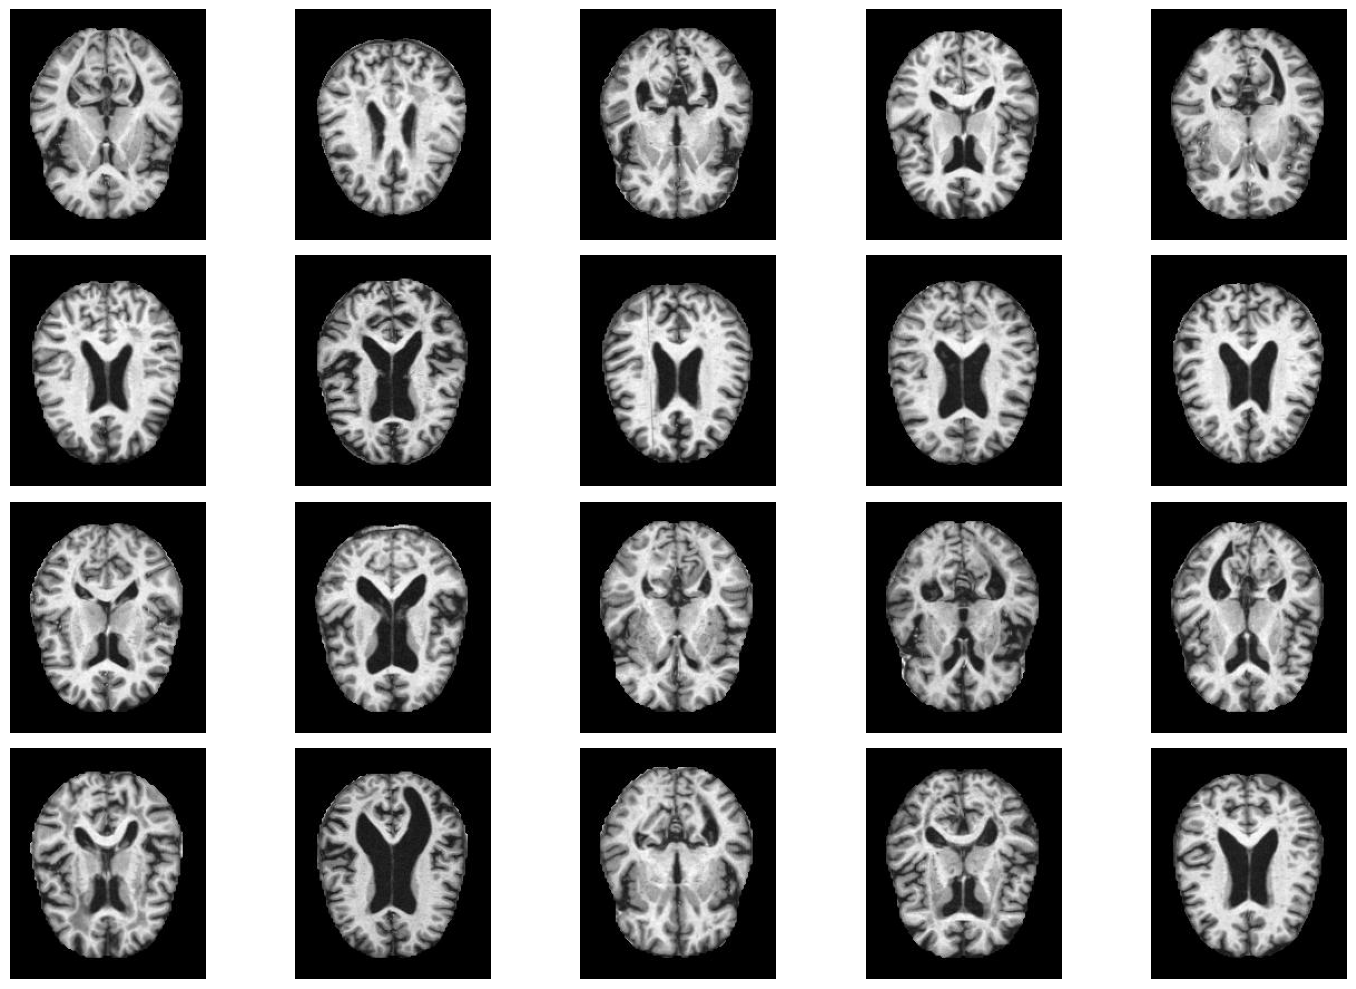

In [12]:
import matplotlib.pyplot as plt

def visualize(dataset, samples=20, part='first'):

    num_images = samples
    rows = samples // 5
    cols = (num_images + rows - 1) // rows  # Round up to ensure all images are displayed

    if part == 'first':
        # Get the last 20 images
        images = dataset[:num_images]
    elif part == 'last':
        images = dataset[-num_images:]
        
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Loop through each image and place it in the appropriate subplot
    for i in range(num_images):
        row = i // cols
        col = i % cols
        axes[row, col].imshow(images[i])
        axes[row, col].axis('off')  # Turn off axis for each subplot

    # Turn off any unused subplots if the number of images doesn't fill all
    for i in range(num_images, rows * cols):
        fig.delaxes(axes.flat[i])

    plt.tight_layout()
    plt.show()
    

print(f'Train datset length before applying ADASYN: {len(X_train)}')
visualize(X_train, 20, 'last')


## After applying ADASYN

In [13]:
# Apply ADASYN
X_balanced, y_balanced = apply_adasyn(X_train, y_train)

Train datset length after applying ADASYN: 9188


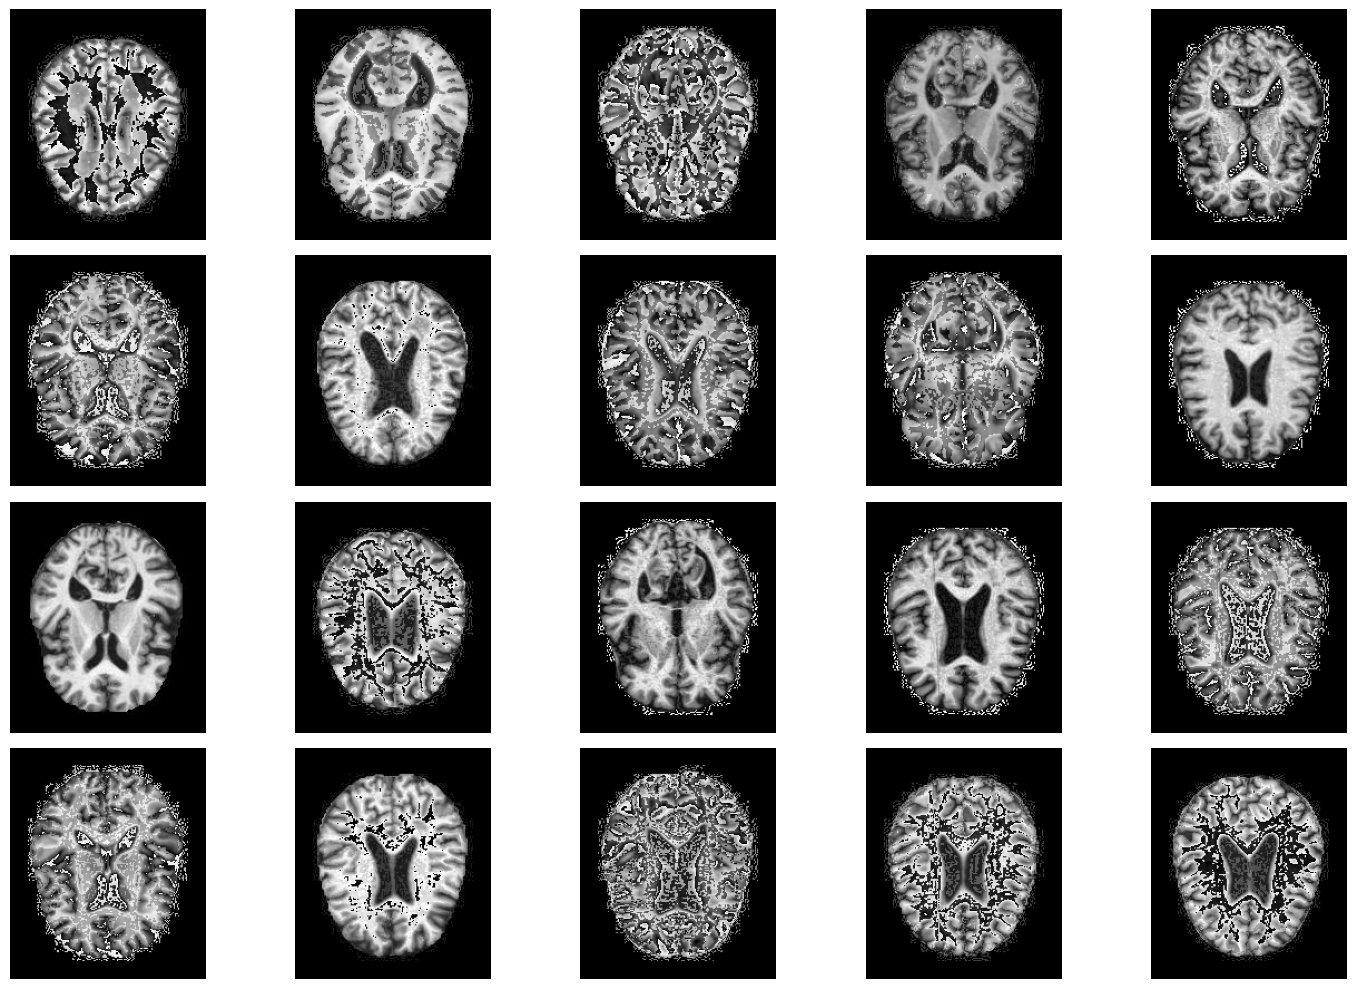

In [14]:
print(f'Train datset length after applying ADASYN: {len(X_balanced)}')
visualize(X_balanced, 20, 'last')

In [15]:
# Define transforms
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [16]:
batch_size = 32

# Create datasets
train_dataset = AlzheimerDataset(X_balanced, y_balanced, transform=transform)
val_dataset = AlzheimerDataset(X_val, y_val, transform=transform)
test_dataset = AlzheimerDataset(X_test, y_test, transform=transform)
    
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)    

In [17]:
print(f'Train datset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(val_dataset)}')
print(f'Test dataset length: {len(test_dataset)}')

Train datset length: 9188
Validation dataset length: 640
Test dataset length: 1280


In [18]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=298544f03c169c7e9bbb41baec33d3d6b57e0d19707e295a1e39b095fb065f88
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


## Train function 

In [19]:
# Training function with tqdm
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs=50, patience=10):
    
    N_test = len(val_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_cost = 0.0
        train_correct = 0

        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)

            optimizer.zero_grad()
            outputs = model(x_train)
            train_loss = criterion(outputs, y_train)
            _, yhat = outputs.max(1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_cost += train_loss.item()
              

        train_cost /= len(train_loader)
        train_cost_list.append(train_cost)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        val_cost = 0.0
        val_correct = 0

        with torch.no_grad():
            for x_test, y_test in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)
                
                outputs_test = model(x_test)
                val_loss = criterion(outputs_test, y_test)
                _, yhat = outputs_test.max(1)
                val_correct += (yhat == y_test).sum().item()
                val_cost += val_loss.item()

        val_cost /= len(val_loader)
        val_cost_list.append(val_cost)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_cost, 4)} | Validation Loss : {round(val_cost, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_cost)

        if val_cost < val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_cost:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_efficientnetb2+vgg16_imb.pt')
            val_loss_min = val_cost
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No reduction in validation loss | Patience count: {patience_counter}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

## Ensemble model (Efficientnetb2+vgg16)

In [20]:
from efficientnet_pytorch import EfficientNet

class EnsembleModel(nn.Module):
    def __init__(self, num_classes=4):
        super(EnsembleModel, self).__init__()

        # Load pre-trained VGG-16 and EfficientNet-B2 models
        self.vgg16 = models.vgg16(pretrained=True)
        self.efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2')
        
        # Remove the classifier (fully connected layers) from both models
        self.vgg16.classifier = nn.Identity()
        self.efficientnet_b2._fc = nn.Identity()

        # Adaptive pooling to ensure consistent spatial dimensions
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Dropout, Batch normalization layers and activation relu
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.batch_norm_flatten = nn.BatchNorm1d(7 * 7 * (512 + 1408)) # Adjusted for EfficientNet-B2 output
        self.batch_norm_256 = nn.BatchNorm1d(256)
        self.batch_norm_64 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(7 * 7 * (512 + 1408), 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Get features from VGG-16
        vgg_features = self.vgg16.features(x)
        vgg_features = self.adaptive_pool(vgg_features)
        
        # Get features from EfficientNet-B2
        efficientnet_features = self.efficientnet_b2.extract_features(x)
        efficientnet_features = self.adaptive_pool(efficientnet_features)

        # Concatenate features along the channel dimension
        concatenated_features = torch.cat((vgg_features, efficientnet_features), dim=1)
        
        # Process combine features
        x = self.dropout1(concatenated_features)
        x = self.flatten(x)
        x = self.batch_norm_flatten(x)
        x = self.fc1(x)
        x = self.batch_norm_256(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.batch_norm_256(x)
        x = self.fc2(x)
        x = self.batch_norm_64(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x


model_vgg16_efficientnet_b2 = EnsembleModel()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s] 
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 106MB/s] 


Loaded pretrained weights for efficientnet-b2


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_vgg16_efficientnet_b2.to(device)

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=50,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/50: 100%|██████████| 20/20 [00:03<00:00,  6.43batch/s]


--> Epoch Number : 1 | Training Loss : 0.8742 | Validation Loss : 1.406 | Train Accuracy : 64.68% | Validation Accuracy : 40.47%
Validation loss decreased (inf --> 1.406046).  Saving model ...


Epoch 2/50: 100%|██████████| 20/20 [00:03<00:00,  6.48batch/s]


--> Epoch Number : 2 | Training Loss : 0.5209 | Validation Loss : 0.7705 | Train Accuracy : 81.56% | Validation Accuracy : 80.31%
Validation loss decreased (1.406046 --> 0.770496).  Saving model ...


Epoch 3/50: 100%|██████████| 20/20 [00:03<00:00,  6.50batch/s]


--> Epoch Number : 3 | Training Loss : 0.3197 | Validation Loss : 0.4966 | Train Accuracy : 90.52% | Validation Accuracy : 87.03%
Validation loss decreased (0.770496 --> 0.496591).  Saving model ...


Epoch 4/50: 100%|██████████| 20/20 [00:03<00:00,  6.55batch/s]


--> Epoch Number : 4 | Training Loss : 0.1975 | Validation Loss : 0.3967 | Train Accuracy : 94.51% | Validation Accuracy : 92.19%
Validation loss decreased (0.496591 --> 0.396696).  Saving model ...


Epoch 5/50: 100%|██████████| 20/20 [00:03<00:00,  6.47batch/s]


--> Epoch Number : 5 | Training Loss : 0.1416 | Validation Loss : 0.4013 | Train Accuracy : 96.48% | Validation Accuracy : 90.78%
No reduction in validation loss | Patience count: 1


Epoch 6/50: 100%|██████████| 20/20 [00:03<00:00,  6.50batch/s]


--> Epoch Number : 6 | Training Loss : 0.1249 | Validation Loss : 0.4089 | Train Accuracy : 96.72% | Validation Accuracy : 92.81%
No reduction in validation loss | Patience count: 2


Epoch 7/50: 100%|██████████| 20/20 [00:03<00:00,  6.47batch/s]


--> Epoch Number : 7 | Training Loss : 0.1078 | Validation Loss : 11.3936 | Train Accuracy : 97.16% | Validation Accuracy : 0.94%
No reduction in validation loss | Patience count: 3


Epoch 8/50: 100%|██████████| 20/20 [00:03<00:00,  6.51batch/s]


--> Epoch Number : 8 | Training Loss : 0.072 | Validation Loss : 0.3774 | Train Accuracy : 98.19% | Validation Accuracy : 95.16%
Validation loss decreased (0.396696 --> 0.377352).  Saving model ...


Epoch 9/50: 100%|██████████| 20/20 [00:03<00:00,  6.51batch/s]


--> Epoch Number : 9 | Training Loss : 0.0657 | Validation Loss : 24.0496 | Train Accuracy : 98.31% | Validation Accuracy : 15.31%
No reduction in validation loss | Patience count: 1


Epoch 10/50: 100%|██████████| 20/20 [00:03<00:00,  6.51batch/s]


--> Epoch Number : 10 | Training Loss : 0.0699 | Validation Loss : 0.3141 | Train Accuracy : 98.15% | Validation Accuracy : 97.03%
Validation loss decreased (0.377352 --> 0.314141).  Saving model ...


Epoch 11/50: 100%|██████████| 20/20 [00:03<00:00,  6.51batch/s]


--> Epoch Number : 11 | Training Loss : 0.051 | Validation Loss : 0.3743 | Train Accuracy : 98.63% | Validation Accuracy : 96.56%
No reduction in validation loss | Patience count: 1


Epoch 12/50: 100%|██████████| 20/20 [00:03<00:00,  6.55batch/s]


--> Epoch Number : 12 | Training Loss : 0.0558 | Validation Loss : 4.1807 | Train Accuracy : 98.42% | Validation Accuracy : 35.0%
No reduction in validation loss | Patience count: 2


Epoch 13/50: 100%|██████████| 20/20 [00:03<00:00,  6.49batch/s]


--> Epoch Number : 13 | Training Loss : 0.0775 | Validation Loss : 0.3979 | Train Accuracy : 97.59% | Validation Accuracy : 95.78%
No reduction in validation loss | Patience count: 3


Epoch 14/50: 100%|██████████| 20/20 [00:03<00:00,  6.39batch/s]


--> Epoch Number : 14 | Training Loss : 0.045 | Validation Loss : 5.5334 | Train Accuracy : 98.67% | Validation Accuracy : 9.22%
No reduction in validation loss | Patience count: 4


Epoch 15/50: 100%|██████████| 20/20 [00:03<00:00,  6.48batch/s]


--> Epoch Number : 15 | Training Loss : 0.0363 | Validation Loss : 1.3756 | Train Accuracy : 99.14% | Validation Accuracy : 95.0%
No reduction in validation loss | Patience count: 5


Epoch 16/50: 100%|██████████| 20/20 [00:03<00:00,  6.46batch/s]


--> Epoch Number : 16 | Training Loss : 0.038 | Validation Loss : 3014.7461 | Train Accuracy : 99.09% | Validation Accuracy : 14.06%
No reduction in validation loss | Patience count: 6


Epoch 17/50: 100%|██████████| 20/20 [00:03<00:00,  6.51batch/s]


--> Epoch Number : 17 | Training Loss : 0.0318 | Validation Loss : 0.3046 | Train Accuracy : 99.16% | Validation Accuracy : 97.81%
Validation loss decreased (0.314141 --> 0.304605).  Saving model ...


Epoch 18/50: 100%|██████████| 20/20 [00:03<00:00,  6.51batch/s]


--> Epoch Number : 18 | Training Loss : 0.0316 | Validation Loss : 0.3297 | Train Accuracy : 99.33% | Validation Accuracy : 98.12%
No reduction in validation loss | Patience count: 1


Epoch 19/50: 100%|██████████| 20/20 [00:03<00:00,  6.46batch/s]


--> Epoch Number : 19 | Training Loss : 0.0209 | Validation Loss : 0.4092 | Train Accuracy : 99.55% | Validation Accuracy : 98.12%
No reduction in validation loss | Patience count: 2


Epoch 20/50: 100%|██████████| 20/20 [00:03<00:00,  6.48batch/s]


--> Epoch Number : 20 | Training Loss : 0.0282 | Validation Loss : 0.314 | Train Accuracy : 99.37% | Validation Accuracy : 98.44%
No reduction in validation loss | Patience count: 3


Epoch 21/50: 100%|██████████| 20/20 [00:03<00:00,  6.49batch/s]


--> Epoch Number : 21 | Training Loss : 0.0277 | Validation Loss : 0.3315 | Train Accuracy : 99.42% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 4


Epoch 22/50: 100%|██████████| 20/20 [00:03<00:00,  6.47batch/s]


--> Epoch Number : 22 | Training Loss : 0.0173 | Validation Loss : 0.3484 | Train Accuracy : 99.56% | Validation Accuracy : 98.12%
No reduction in validation loss | Patience count: 5


Epoch 23/50: 100%|██████████| 20/20 [00:03<00:00,  6.52batch/s]


--> Epoch Number : 23 | Training Loss : 0.0189 | Validation Loss : 0.349 | Train Accuracy : 99.59% | Validation Accuracy : 98.28%
No reduction in validation loss | Patience count: 6


Epoch 24/50: 100%|██████████| 20/20 [00:03<00:00,  6.45batch/s]


--> Epoch Number : 24 | Training Loss : 0.0191 | Validation Loss : 0.3651 | Train Accuracy : 99.51% | Validation Accuracy : 98.44%
No reduction in validation loss | Patience count: 7


Epoch 25/50: 100%|██████████| 20/20 [00:03<00:00,  6.48batch/s]


--> Epoch Number : 25 | Training Loss : 0.0218 | Validation Loss : 0.3371 | Train Accuracy : 99.47% | Validation Accuracy : 98.44%
No reduction in validation loss | Patience count: 8


Epoch 26/50: 100%|██████████| 20/20 [00:03<00:00,  6.50batch/s]


--> Epoch Number : 26 | Training Loss : 0.0235 | Validation Loss : 0.3434 | Train Accuracy : 99.43% | Validation Accuracy : 98.12%
No reduction in validation loss | Patience count: 9


Epoch 27/50: 100%|██████████| 20/20 [00:03<00:00,  6.51batch/s]

--> Epoch Number : 27 | Training Loss : 0.0195 | Validation Loss : 0.3776 | Train Accuracy : 99.65% | Validation Accuracy : 98.12%
No reduction in validation loss | Patience count: 10
Early stopping triggered.


## Performance curves 

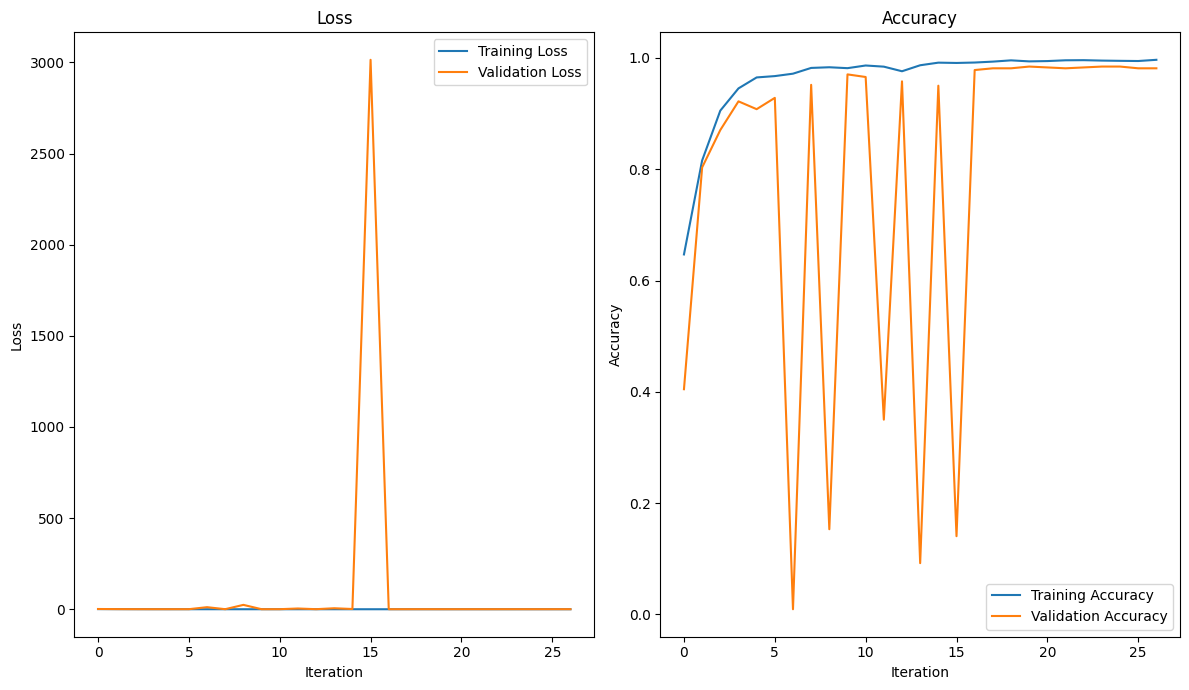

In [30]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


## Test function

In [24]:
def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    test_cost = 0.0
    test_correct = 0
    N_test = len(test_loader.dataset)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            
            test_cost += test_loss.item()
            _, yhat = outputs.max(1)
            test_correct += (yhat == labels).sum().item()
    
    test_cost /= len(test_loader)
    test_acc = test_correct / N_test
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [25]:
best_model = model
best_model.load_state_dict(torch.load('model_efficientnetb2+densenet121_imb.pt'))
test_model(best_model, test_loader, criterion)

Test Loss: 0.3195, Test Acc: 0.9805


## Classification report #

In [26]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    
    # Forward pass
    with torch.no_grad():
        outputs = best_model(x)
        _, yhat = outputs.max(1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


                  precision    recall  f1-score   support

    MildDemented       0.99      0.97      0.98       179
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.98      0.99      0.99       640
VeryMildDemented       0.97      0.98      0.97       448

        accuracy                           0.98      1280
       macro avg       0.99      0.98      0.98      1280
    weighted avg       0.98      0.98      0.98      1280



## Confusion matrix

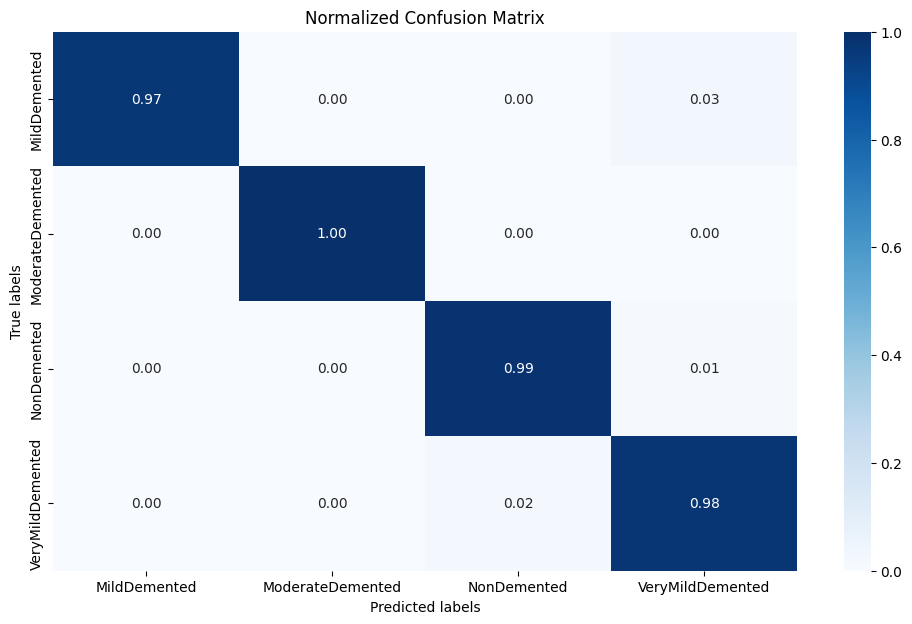

In [27]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix by each class's sample count
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cf_matrix_normalized, index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.savefig('output.png')
plt.show()


## ROC/AUC

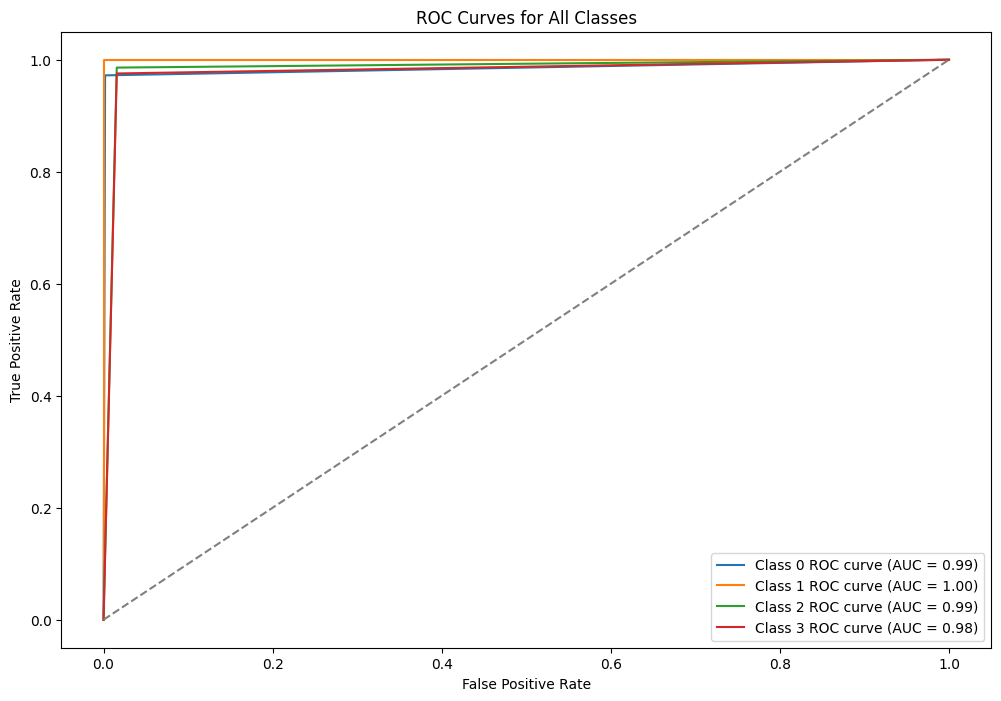

AUC for class 0: 0.99
AUC for class 1: 1.00
AUC for class 2: 0.99
AUC for class 3: 0.98


In [28]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for all classes on a single graph
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i} ROC curve (AUC = {all_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC for each class
for i, auc_value in enumerate(all_auc):
    print(f'AUC for class {i}: {auc_value:.2f}')


## Combine ROC/AUC

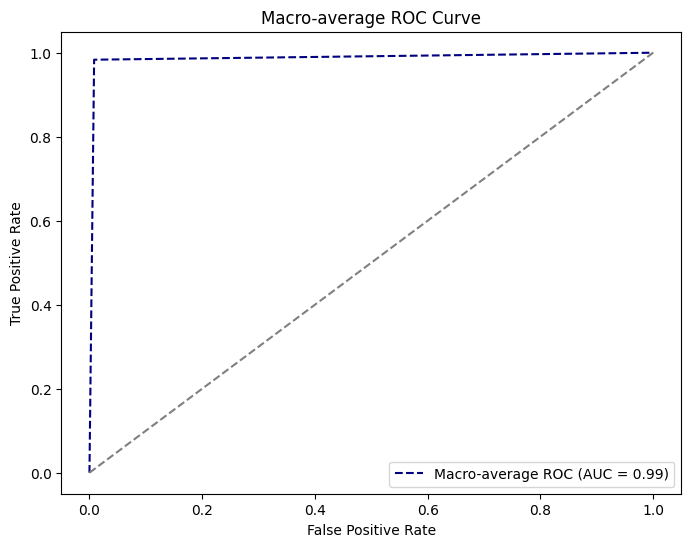

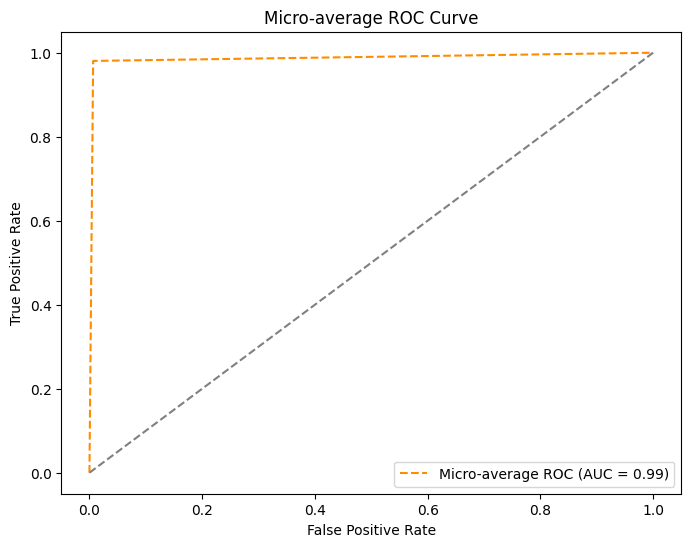

In [29]:
from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()
